In [1]:

# Get current file path
import inspect
import os
import sys

import numpy as np
from Basilisk.utilities import orbitalMotion, macros

filename = inspect.getframeinfo(inspect.currentframe()).filename
path = os.getcwd()

# Import master classes: simulation base class and scenario base class
sys.path.append(path + '/../')
sys.path.append(path + '/../models')
sys.path.append(path + '/../plotting')
from sim_masters import Sim, Scenario
import cubesat_dynamics, cubesat_fsw
import cubesat_plotting as plots



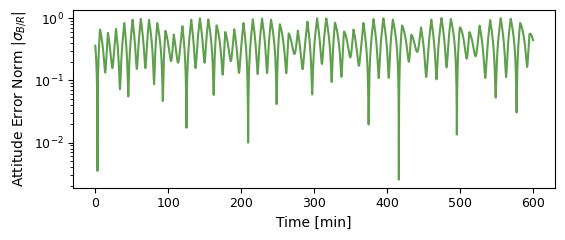

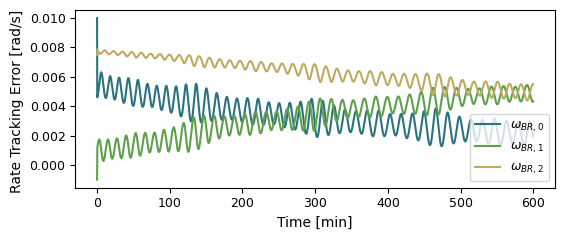

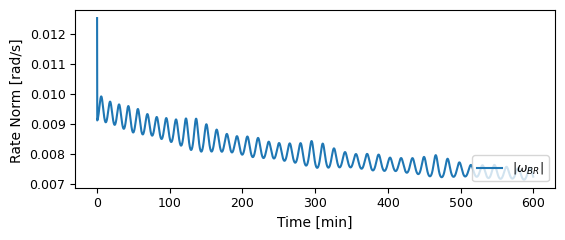

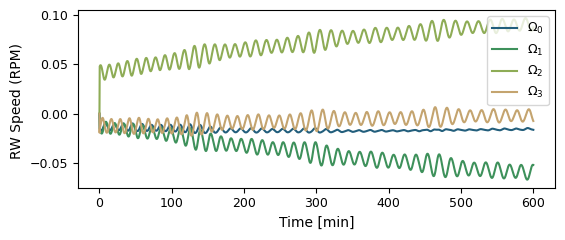

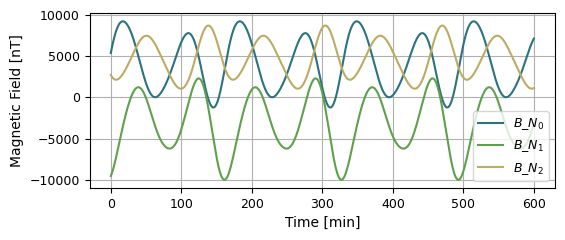

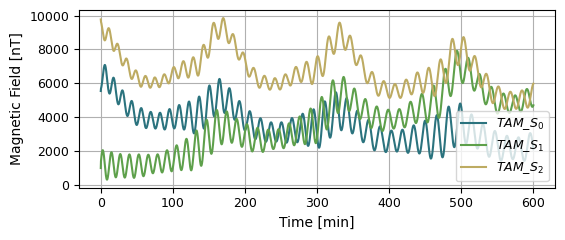

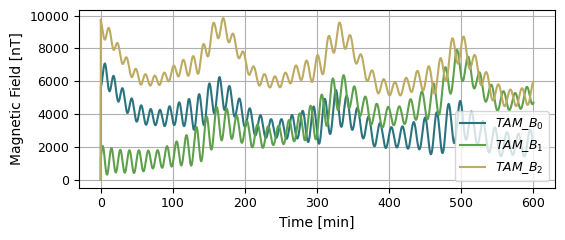

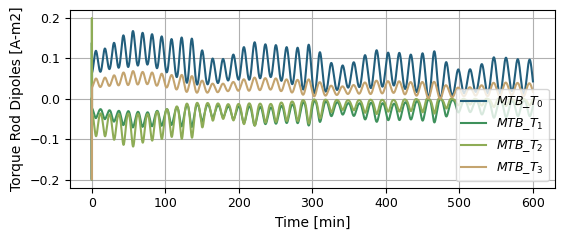

In [3]:

# Create your own scenario child class
class Scenario_mtb_detumble(Sim, Scenario):
    def __init__(self):
        super(Scenario_mtb_detumble, self).__init__()
        self.name = 'scenario_MtbDetumble'

        # declare additional class variables
        self.sNavTransName = "sNavTransMsg"
        self.attGuidName = "attGuidMsg"

        self.set_DynModel(cubesat_dynamics)
        self.set_FswModel(cubesat_fsw)

        self.configure_initial_conditions()
        self.log_outputs()

    def configure_initial_conditions(self):
        # Configure Dynamics initial conditions
        oe = orbitalMotion.ClassicElements()
        oe.a = 10000000.0  # meters
        oe.e = 0.01
        oe.i = 33.3 * macros.D2R
        oe.Omega = 48.2 * macros.D2R
        oe.omega = 347.8 * macros.D2R
        oe.f = 85.3 * macros.D2R

        DynModels = self.get_DynModel()
        mu = DynModels.gravFactory.gravBodies['earth'].mu
        rN, vN = orbitalMotion.elem2rv(mu, oe)
        orbitalMotion.rv2elem(mu, rN, vN)
        DynModels.scObject.hub.r_CN_NInit = rN  # m   - r_CN_N
        DynModels.scObject.hub.v_CN_NInit = vN  # m/s - v_CN_N
        DynModels.scObject.hub.sigma_BNInit = [[0.1], [0.2], [-0.3]]  # sigma_CN_B
        DynModels.scObject.hub.omega_BN_BInit = [[0.01], [-0.001], [0.0075]]  # rad/s - omega_CN_B
    

    def log_outputs(self):
        FswModel = self.get_FswModel()
        DynModel = self.get_DynModel()
        samplingTime = FswModel.processTasksTimeStep
        
        self.scStateLog = DynModel.scObject.scStateOutMsg.recorder(samplingTime)
        self.magLog = DynModel.mag_field_module.envOutMsgs[0].recorder(samplingTime)
        self.tamLog = DynModel.tam_module.tamDataOutMsg.recorder(samplingTime)
        self.tamCommLog = FswModel.tam_com_module.tamOutMsg.recorder(samplingTime)
        self.mtbDipoleCmdsLog = FswModel.mtbCmdMsg.recorder(samplingTime)

        self.AddModelToTask(DynModel.taskName, self.scStateLog)
        self.AddModelToTask(DynModel.taskName, self.magLog)
        self.AddModelToTask(DynModel.taskName, self.tamLog)
        self.AddModelToTask(DynModel.taskName, self.tamCommLog)
        self.AddModelToTask(DynModel.taskName, self.mtbDipoleCmdsLog)

        # To log the RW information, the following code is used:
        self.mrpLog = DynModel.rwStateEffector.rwSpeedOutMsg.recorder(samplingTime)
        self.AddModelToTask(DynModel.taskName, self.mrpLog)
        self.rwLogs = []
        for item in range(4):
            self.rwLogs.append(DynModel.rwStateEffector.rwOutMsgs[item].recorder(samplingTime))
            self.AddModelToTask(DynModel.taskName, self.rwLogs[item])

    def pull_outputs(self, show_plots):
        dataSigmaBN = np.delete(self.scStateLog.sigma_BN, 0, 0)
        dataOmegaBN = np.delete(self.scStateLog.omega_BN_B, 0, 0)
        dataOmegaRW = np.delete(self.mrpLog.wheelSpeeds, 0, 0)
        dataRW = []
        for i in range(4):
            dataRW.append(np.delete(self.rwLogs[i].u_current, 0, 0))
        dataMagField = np.delete(self.magLog.magField_N, 0, 0)
        dataTam = np.delete(self.tamLog.tam_S, 0, 0)
        dataTamComm = np.delete(self.tamCommLog.tam_B, 0, 0)
        dataMtbDipoleCmds = np.delete(self.mtbDipoleCmdsLog.mtbDipoleCmds, 0, 0)

        # Plot results
        plots.clear_all_plots()
        #   plot the results
        timeData = np.delete(self.scStateLog.times(), 0, 0) * macros.NANO2MIN

        figureList = {}
        plots.plot_attitude_error(timeData, dataSigmaBN)
        plots.plot_rate_error(timeData, dataOmegaBN)
        plots.plot_rate_norm(timeData, dataOmegaBN)
        plots.plot_rw_speeds(timeData, dataOmegaRW, 4)
        plots.plot_magnetic_field(timeData, dataMagField)
        plots.plot_data_tam(timeData, dataTam)
        plots.plot_data_tam_comm(timeData, dataTamComm)
        plots.plot_data_mtb_momentum_management(timeData, dataMtbDipoleCmds, self.get_DynModel().mtbConfigParams.numMTB)

        if show_plots:
            plots.show_all_plots()
        else:
            fileName = os.path.basename(os.path.splitext(__file__)[0])
            figureNames = ["attitudeErrorNorm", "rateError"]
            figureList = plots.save_all_plots(fileName, figureNames)

        return figureList


def runScenario(scenario):
    """method to initialize and execute the scenario"""
    simulationTime = macros.min2nano(600.)
    scenario.InitializeSimulation()
    # Configure run time and execute simulation
    scenario.modeRequest = 'mtb_detumble'
    scenario.ConfigureStopTime(simulationTime)
    scenario.ExecuteSimulation()

    return


def run(show_plots):
    scenario = Scenario_mtb_detumble()
    runScenario(scenario)
    figureList = scenario.pull_outputs(show_plots)
    return

run(True)